<a href="https://colab.research.google.com/github/kmkarakaya/ML_tutorials/blob/master/Sampling_in_Text_Generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
# PREPARATION

In [ ]:
import tensorflow as tf
import tensorflow.keras.backend as K
import numpy as np
from tensorflow.keras import layers
from tensorflow.keras import layers, Model
import os
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
import string
import re
import matplotlib.pyplot as plt

In [ ]:
tf.__version__

'2.4.1'

In [ ]:
#@title Record Each Cell's Execution Time
#!pip install ipython-autotime

#%load_ext autotime

In [ ]:
#pip install --upgrade tensorflow

---
# Sampling in Text Generation


This tutorial is the **fourth** part of the "**Text Generation in Deep Learning with Tensorflow & Keras**" series.

In this series, we have been covering all the  topics related to Text Generation with sample implementations in **Python**.

In this tutorial, we will focus on how to **sample (select) the next token in Text Generation**.

**First**, we will introduce the text generation process. 

**Then**, we will briefly present the most common methods of sampling.

**Afterward**, we will implement three sampling methods: Greedy Sampling, Temperature Sampling, and Top-k sampling. We will discuss the advantages and disadvantages of these methods as well.

Thus, **in the end**, we will understand the sampling in Text Generation and prepare implementation of three popular sampling methods to use in upcoming parts for word-level text generation.


If you would like to learn more about **Deep Learning** with practical coding examples, please subscribe to [Murat Karakaya Akademi YouTube Channel](https://www.youtube.com/channel/UCrCxCxTFL2ytaDrDYrN4_eA)  or follow [my blog on Medium](https://medium.com/@kmkarakaya). Do not forget to turn on **notifications** so that you will be notified when new parts are uploaded.

You can access this **Colab Notebook** using the link given in the video description below.

If you are ready, let's get started!



## [Text Generation in Deep Learning with Tensorflow & Keras Series:](https://kmkarakaya.medium.com/text-generation-in-deep-learning-with-tensorflow-keras-e403aee375c1)

**Part A**: Fundamentals 

**Part B**: Tensorflow Data Pipeline for Character Level Text Generation

**Part C**: Tensorflow Data Pipeline for Word Level Text Generation

**Part D**: ***Sampling in Text Generation***

**Part E**: Recurrent Neural Network (LSTM) Model for Character Level Text Generation

**Part F**: Encoder-Decoder Model for Character Level Text Generation

**Part G**: Recurrent Neural Network (LSTM) Model for Word Level Text Generation

**Part H**: Encoder-Decoder Model for Word Level Text Generation


You can **watch** all these parts on [Murat Karakaya Akademi channel on YouTube](https://www.youtube.com/channel/UCrCxCxTFL2ytaDrDYrN4_eA) in **[ENGLISH](https://youtube.com/playlist?list=PLQflnv_s49v9QOres0xwKyu21Ai-Gi3Eu)** or **[TURKISH](https://youtube.com/playlist?list=PLQflnv_s49v-oEYNgoqK5e4GyUbodfET3)**

I **assume** that ***you have already watched all previous parts***.

Please ensure that you have reviewed the previous parts in order to utilize this part better.



## References

[What is a Data Pipeline?](https://www.alooma.com/blog/what-is-a-data-pipeline)


[tf.data: Build TensorFlow input pipelines](https://www.tensorflow.org/guide/data)


[Text classification from scratch](https://keras.io/examples/nlp/text_classification_from_scratch/)

[Working with Keras preprocessing layers](https://keras.io/guides/preprocessing_layers/)

[Character-level text generation with LSTM](https://keras.io/examples/generative/lstm_character_level_text_generation/)


[Toward Controlled Generation of Text](https://arxiv.org/abs/1703.00955)

[Attention Is All You Need](https://arxiv.org/abs/1706.03762)

[Talk to Transformer](https://app.inferkit.com/demo)

[What is the difference between word-based and char-based text generation RNNs?](https://datascience.stackexchange.com/questions/13138/what-is-the-difference-between-word-based-and-char-based-text-generation-rnns)

[The survey: Text generation models in deep learning](https://www.sciencedirect.com/science/article/pii/S1319157820303360)

[Generative Adversarial Networks for Text Generation](https://becominghuman.ai/generative-adversarial-networks-for-text-generation-part-1-2b886c8cab10)

[FGGAN: Feature-Guiding Generative Adversarial Networks for Text Generation](https://ieeexplore.ieee.org/abstract/document/9091179)

[How to sample from language models](https://towardsdatascience.com/how-to-sample-from-language-models-682bceb97277)

[How to generate text: using different decoding methods for language generation with Transformers](https://huggingface.co/blog/how-to-generate)

[Hierarchical Neural Story Generation](https://arxiv.org/abs/1805.04833)

[How to sample from language models](https://towardsdatascience.com/how-to-sample-from-language-models-682bceb97277)

[Text generation with LSTM](https://jjallaire.github.io/deep-learning-with-r-notebooks/notebooks/8.1-text-generation-with-lstm.nb.html)

[A guide to language model sampling in AllenNLP](https://medium.com/ai2-blog/a-guide-to-language-model-sampling-in-allennlp-3b1239274bc3)

[Generating text from language model](https://stats.stackexchange.com/questions/501496/generating-text-from-language-model)

[How to Implement a Beam Search Decoder for Natural Language Processing](https://machinelearningmastery.com/beam-search-decoder-natural-language-processing/)

[Controllable Neural Text Generation](https://lilianweng.github.io/lil-log/2021/01/02/controllable-neural-text-generation.html)


In [2]:
#@title You can watch this notebook for more verbal explanations. https://youtu.be/0RFQ6QOYL68
from IPython.display import HTML

# Youtube
HTML('<iframe width="400" height="300" src="https://www.youtube.com/embed/0RFQ6QOYL68?rel=0&amp;controls=0&amp;showinfo=0" frameborder="0" allowfullscreen></iframe>')

# What is  Text Generation?
A **Language Model (LM)** can be trained to generate text **word-by-word** or **character-by-character**. 

The input and output sequences given to the **LM** are made of tokens that are either a **word** or a **character**. 

In training, we supply a sequence of tokens as input (X) and a target token (next token to complete the input) as output (y)

After training, the Language Model learns to generate **a conditional probability distribution** over the **vocabulary** of tokens according to the **given  input sequence**.

Below, you see a **word-level** LM predicts  **a conditional probability distribution** over the word dictionary for the given word sequences "*I want to cook*"


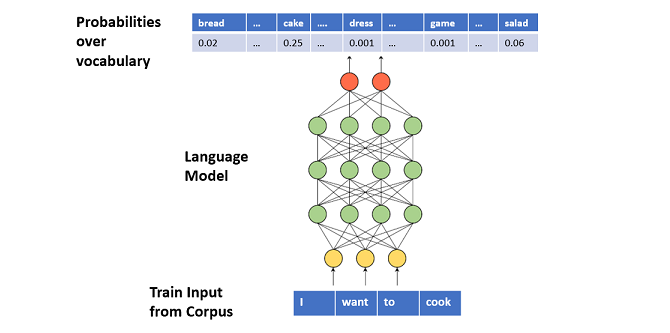

To generate text, we can iterate over the below steps: 
* **Step 1:** we provide **a sequence of words** to the Language Model as input
* **Step 2:** the Language Model outputs **a conditional probability distribution** over the **vocabulary**
* **Step 3:** we **sample** a word from the distribution
* **Step 4:** we **concatenate** the newly sampled word to the ***generated text***
* **Step 5:** **a new input sequence** is genereted by appending the newly sampled word


For more details, please check [Part A,  B, and C.](https://medium.com/mlearning-ai/text-generation-in-deep-learning-with-tensorflow-keras-f7cfd8d65d9e)

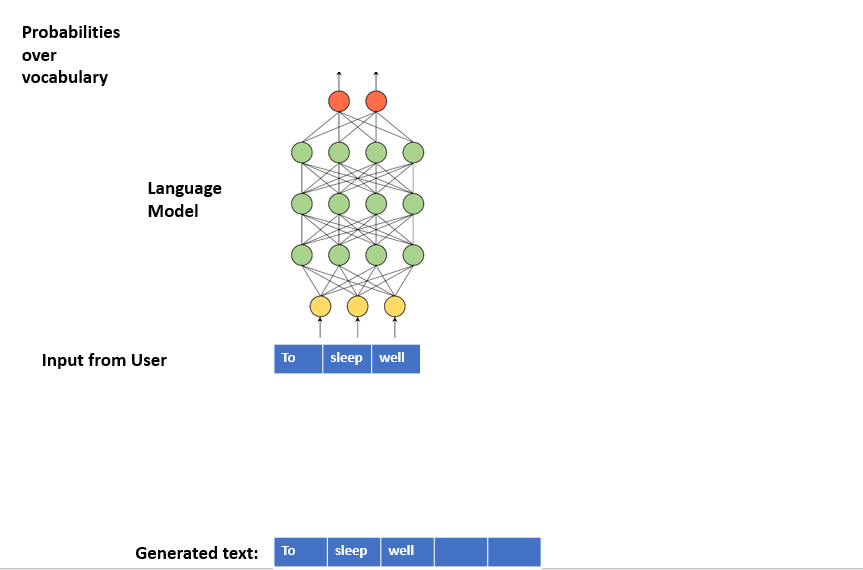

# Sampling
In Text Generation, **sampling** means randomly **picking** the next token according to the generated **conditional probability distribution**.

That is, after generating the conditional  probability distribution over the set of tokens (*vocabulary*) for the given input sequence, we need to  carefully decide how to **select the next token** (***sample***) from this distribution. 



There are **several methods for sampling** in text generation (see [here](https://towardsdatascience.com/how-to-sample-from-language-models-682bceb97277) and [here](https://huggingface.co/blog/how-to-generate)):


* **Greedy Search (Maximization)** 


* **Temperature Sampling**

* **Top-K Sampling**
* **Top-P Sampling (Nucleus sampling)**

* **Beam Search**

In this tutorial, we will code Greedy Search, Temperature Sampling, and Top-K Sampling. 

In the end of the tutorial, I will introduce the Top-P Sampling and Beam Search briefly.


---
# 1. TRAIN A LANGUAGE MODEL


In this tutorial, since we are **more interested** in **sampling** methods and their implementations, we will **simulate** the conditional probability distribution over the token vocabulary by ***assuming*** that:


* We opt to generate text **character-by-character**. 

* We have a **vocabulary** of characters from **'a'** to **'z'**.

* We have already trained the **Language Model** with a corpus.
* Thus, the Language Model is ready to generate a **conditional probability distribution** over the  **token vocabulary** for a given input sequence.

* Now, we want to **sample** (select) the **next token** from the **conditional probability distribution**.

Let's prepare the simulated LM.


## Define the vocabulary



In [ ]:
dictionary =[]
for c in range(ord('a'), ord('z')+1):
  dictionary.append(chr(c))
dictionary

['a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z']

## Simulate the trained LM:

In [ ]:
class language_model:
  def __init__(self, dictionary):
    self.dictionary = dictionary
  def predict(self):
    output= np.random.rand(len(dictionary))
    output=output/output.sum()
    return  output

model=language_model(dictionary)


## Simulate the generation of the conditional probability distribution:

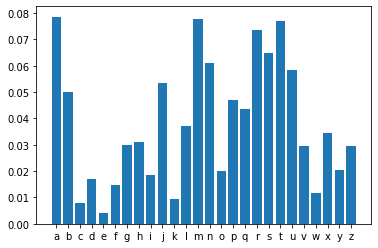

In [ ]:
predictions= model.predict()
plt.bar(dictionary,predictions)
plt.show()

In [ ]:
predictions.sum()

1.0000000000000002

Now, we can code several sampling methods and observe their behaviors.

---
# 2. SAMPLING BY GREEDY SEARCH

**Greedy search** method simply ***selects*** the token with the **highest probability** as its next token (*word or char*). 

However, if we always sample the  most likely word, the standard language model training objective causes us to **get stuck in loops** like 

“*I don’t know. I don’t know. I don’t know. I don’t know.*”

In [ ]:
def greedy_search(conditional_probability):
  return (np.argmax(conditional_probability))

In [ ]:
next_token = greedy_search(predictions)
print("Sampled token: ",dictionary[next_token])

Sampled token:  a


---
# 3. TEMPERATURE SAMPLING: 

 

Temperature sampling is inspired by statistical thermodynamics, where ***high temperature*** means low energy states are more likely encountered. 

In probability models, **logits** play the role of energy and we can implement temperature sampling by **dividing logits by the temperature** before feeding them into ***softmax*** and obtaining our sampling probabilities.

  Below is an implementation for Temperature Sampling [taken from here](https://keras.io/examples/generative/lstm_character_level_text_generation/)




## 3.1 Drawing from the model a probability distribution over the next character given the text available so far



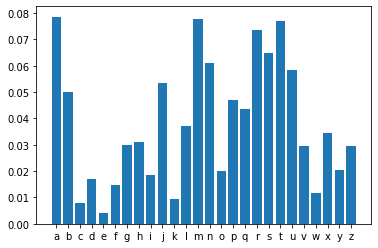

In [ ]:
plt.bar(dictionary,predictions)
plt.show()

## 3.2 Reweighting the distribution to a certain “temperature”




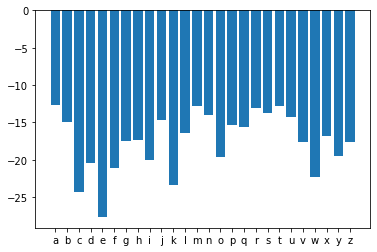

In [ ]:
temperature=0.2
conditional_probability = np.asarray(predictions).astype("float64")
conditional_probability = np.log(conditional_probability) / temperature
plt.bar(dictionary,conditional_probability)
plt.show()

## 3.3 We can apply the **softmax** function. 
The softmax function transforms each element of a collection by computing the **exponential of each element** ***divided by*** the **sum of the exponentials of all** the elements. That is, if x is a one-dimensional numpy array:

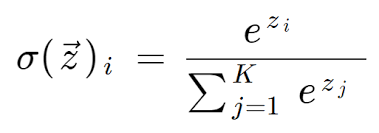

We can define our own function or use `scipy.special.softmax()` or `tf.keras.layers.Softmax()`. 

Let's define it as a function:

In [ ]:
def softmax(z):
   return np.exp(z)/sum(np.exp(z))

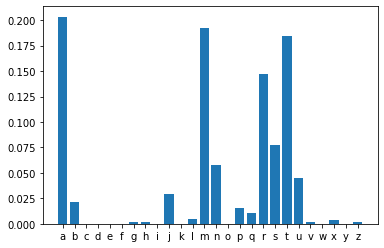

In [ ]:
reweighted_conditional_probability = softmax(conditional_probability)
plt.bar(dictionary,reweighted_conditional_probability)
plt.show()

## 3.4 Sampling the next character randomly according to the reweighted distribution

We can draw a sample using a **multinomial distribution**. 

The **parameters** of the multinomial distribution function are: 
* **n**: int, Number of experiments.

* **pvals**: sequence of floats, length p. Probabilities of each of the p different outcomes. These must sum to 1 (however, the last element is always assumed to account for the remaining probability, as long as sum(pvals[:-1]) <= 1).

* **size**: int or tuple of ints, optional. Output shape. If the given shape is, e.g., (m, n, k), then m * n * k samples are drawn. Default is None, in which case a single value is returned.

We will call the multinomial distribution function with the parameters `(1, reweighted_conditional_probability, 1)` because we want only **1 draw experiment** from **reweighted_conditional_probability** to select (sample) **1 output**. 

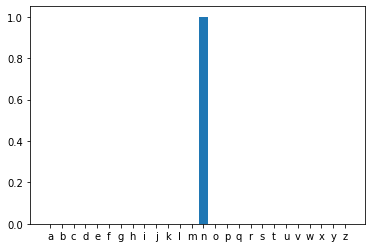

In [ ]:
probas = np.random.multinomial(1, reweighted_conditional_probability, 1)
plt.bar(dictionary,np.squeeze(probas))
plt.show()

## 3.5 Put all the steps together as a function

In [ ]:
def temperature_sampling (conditional_probability, temperature=1.0):
    conditional_probability = np.asarray(conditional_probability).astype("float64")
    conditional_probability = np.log(conditional_probability) / temperature
    reweighted_conditional_probability = softmax(conditional_probability)
    probas = np.random.multinomial(1, reweighted_conditional_probability, 1)
    plt.bar(dictionary,reweighted_conditional_probability)
    plt.show()
    return np.argmax(probas)

Note that model **predicts** the below ***conditional probability distribution*** over the vocabulary 

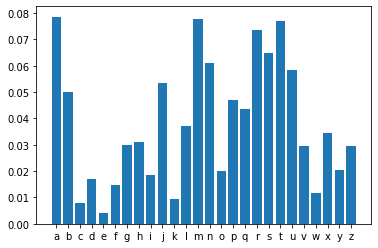

In [ ]:
plt.bar(dictionary,predictions)
plt.show()

After applying **temperature sampling** with ***different temperature values***, we have the following **updated** ***conditional probability*** distributions over the vocabulary for the given **temperature values**:

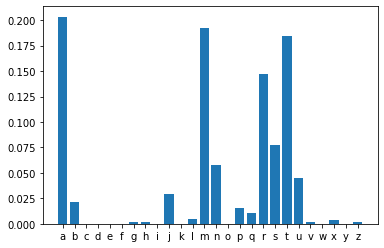

Temperature:  0.2
Sampled token:  r 



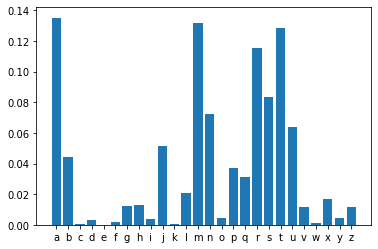

Temperature:  0.4
Sampled token:  m 



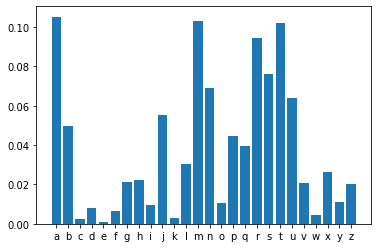

Temperature:  0.6000000000000001
Sampled token:  t 



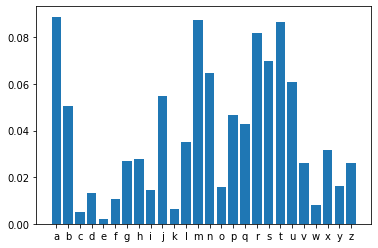

Temperature:  0.8
Sampled token:  t 



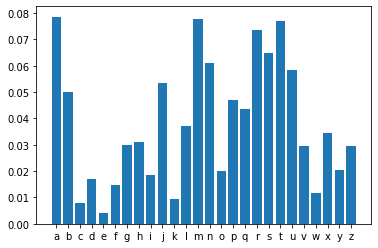

Temperature:  1.0
Sampled token:  d 



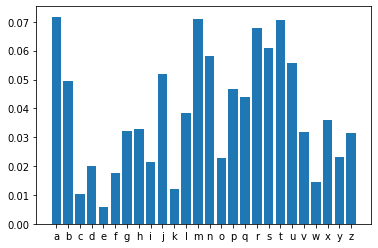

Temperature:  1.2
Sampled token:  s 



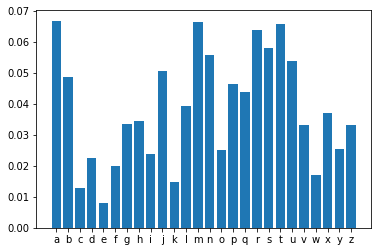

Temperature:  1.4000000000000001
Sampled token:  h 



In [ ]:
for temp in np.arange(0.2,1.6,0.2):
  
  next_token = temperature_sampling(predictions, temperature=temp)
  print("Temperature: ", temp)
  print("Sampled token: ",dictionary[next_token],"\n")



## 3.6 Observations
[In most of the researches](https://jjallaire.github.io/deep-learning-with-r-notebooks/notebooks/8.1-text-generation-with-lstm.nb.html), it is noted that:


* If **temperature** is set to v**ery low values or 0**, then Temperature Sampling becomes **equivalent** to the **Greedy Search** by  always picking the next token with the highest probability.

* A **low temperature** results in extremely **repetitive** and **predictable** text, but where local structure is highly **realistic**: in particular, all words (a word being a local pattern of characters) are real words from the corpus. 

* With **higher temperatures**, the generated text becomes more **random**, **interesting**, **surprising**, even creative; it may sometimes invent completely new words (*misspelled words*) that sound somewhat **plausible**. 

* With a **high temperature**, the local structure starts breaking down and most words look like **semi-random strings** of characters. 

* Always **experiment with multiple temperature values**! A clever balance between learned structure and randomness is what makes generation interesting.



# 4. TOP-K SAMPLING

[Fan et. al (2018)](https://arxiv.org/abs/1805.04833) introduced a simple, but very powerful sampling scheme, called Top-K sampling. 

In Top-K sampling, the **K most likely next words** are filtered and the **probability** mass is **redistributed** among only those K next words. 

**GPT2** adopted this sampling scheme, which was one of the reasons for its success in **story generation**.

To apply the Top-k sampling, we sort all the tokens accoding to the probabilites and zero-ing out the probabilities for anything below the k’th token. 




## 4.1 Let's have a conditional probability distribution over the dictionary.

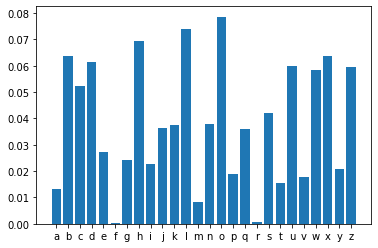

In [ ]:
predictions= model.predict()
plt.bar(dictionary,predictions)
plt.show()

## 4.2 Select the top-k probabilities

We can use `tf.math.top_k()` function to find the **k largest** entries in the vector and outputs their **values** and **indices** as vectors.

Using the **indices**, we can record the token names for plotting names of the tokens.



In [ ]:
k=5
top_k_probabilities, top_k_indices= tf.math.top_k(predictions, k=k, sorted=True)
top_k_indices = np.asarray(top_k_indices).astype("int32")
top_k_tokens=[dictionary[i] for i in top_k_indices]
top_k_indices, top_k_tokens

(array([14, 11,  7, 23,  1], dtype=int32), ['o', 'l', 'h', 'x', 'b'])

## 4.3 We can apply the **softmax** function on these tokens

In [ ]:
top_k_redistributed_probability=softmax(np.log(top_k_probabilities))
top_k_redistributed_probability = np.asarray(top_k_redistributed_probability).astype("float32")
print('top_k_tokens: ',top_k_tokens)
print('top_k_redistributed_probability: ',top_k_redistributed_probability)
print('Total probability: ', top_k_redistributed_probability.sum())

top_k_tokens:  ['o', 'l', 'h', 'x', 'b']
top_k_redistributed_probability:  [0.22512405 0.21178281 0.19833136 0.1825569  0.18220489]
Total probability:  1.0


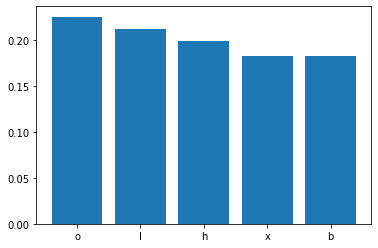

In [ ]:
plt.bar(top_k_tokens,top_k_redistributed_probability)
plt.show()

## 4.4  Sampling the next character randomly according to the reweighted distribution

In [ ]:
sampled_token = np.random.choice(top_k_indices, p=top_k_redistributed_probability)
print("Sampled token id: ",sampled_token, " token: ",dictionary[sampled_token])

Sampled token id:  11  token:  l


## 4.5 Put all the steps together as a function

In [ ]:
  def top_k_sampling(conditional_probability, k):
    top_k_probabilities, top_k_indices= tf.math.top_k(predictions, k=k, sorted=True)
    top_k_indices = np.asarray(top_k_indices).astype("int32")
    top_k_redistributed_probability=softmax(np.log(top_k_probabilities))
    top_k_redistributed_probability = np.asarray(top_k_redistributed_probability).astype("float32")
    sampled_token = np.random.choice(top_k_indices, p=top_k_redistributed_probability)
    top_k_tokens=[dictionary[i] for i in top_k_indices]
    plt.bar(top_k_tokens,top_k_redistributed_probability)
    plt.show()
    return sampled_token

Let's remember the predictions from the model once more:

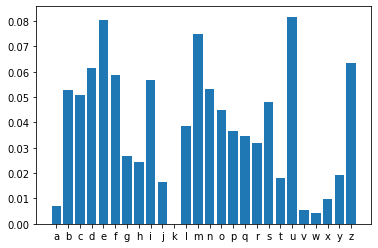

In [ ]:
predictions= model.predict()
plt.bar(dictionary,predictions)
plt.show()

## 4.6 After applying top-k sampling with **different k values**

We have the following updated conditional probability distributions over the vocabulary for the given k values:

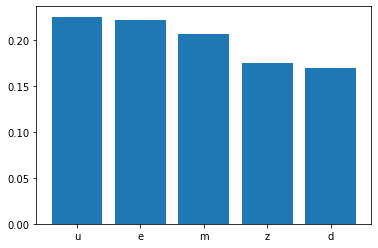

k:  5
Sampled token:  u 



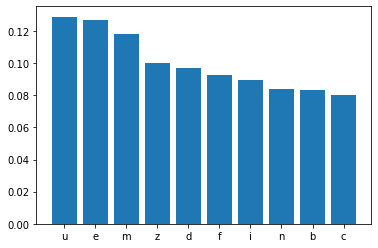

k:  10
Sampled token:  n 



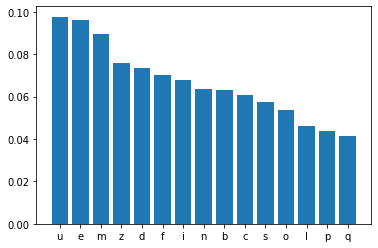

k:  15
Sampled token:  e 



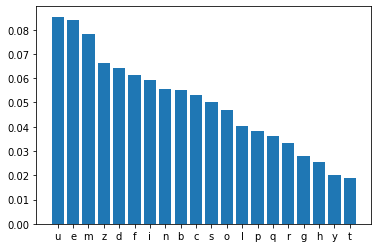

k:  20
Sampled token:  z 



In [ ]:
for k in range (5, 25, 5):
  next_token = top_k_sampling(predictions, k=k)
  print("k: ", k)
  print("Sampled token: ",dictionary[next_token],"\n")

## 4.7 Observations

In the studies, it is reported that the top-k sampling appears to **improve quality** by **removing the tail** and making it less likely to go off topic. 

However in some cases, 
* there are **many tokens** we could sample from reasonably (***broad distribution***), and 

* in some cases, there are **few tokens** (***narrow distribution***).

Therefore, **k** value should be chosen **carefully**.


# 5. OTHER SAMPLING METHODS

There are many other methods proposed for sampling. The below ones  are the most common. I leave their implementation to you as an exercise :)

* **Top-P Sampling (Nucleus sampling)**: Another way to exclude very low probability tokens is to include the most probable tokens that make up the “nucleus” of the probability mass function (PMF), such that the **sum of the most probable tokens just reaches** ***p***. In other words, based on a parameter 0<=p<=1, Top-P Sampling aggregates the **smallest set of words that have summed probability mass p**. It can be thought of as a variation of top-k sampling with dynamic k. For details check [this blog](https://medium.com/ai2-blog/a-guide-to-language-model-sampling-in-allennlp-3b1239274bc3).


* **Beam Search**: Beam search reduces the risk of missing hidden high probability token sequences by keeping the most likely num_beams of hypotheses at each time step and eventually choosing the hypothesis that has the overall highest probability. For details check [this blog](https://huggingface.co/blog/how-to-generate) and [that one](https://machinelearningmastery.com/beam-search-decoder-natural-language-processing/).

  **Beam search** will always find an output sequence with **higher** probability than **greedy search**, but is not guaranteed to find the most likely output.

---
## CONCLUSION:
In this tutorial, we discussed the **sampling** in text generation and **codded three sampling methods**.

We also discussed the **pros and cons** of these methods.

In general, it is advised to experiment with **multiple sampling methods**. 

Moreover, it is a good idea to set the parameters of these models such that a **balance between learned structure and randomness** is created. 

In this way, we can expect to **generate an interesting text**.

If you'd like, you can implement the ***Top-P Sampling and Beam Search*** by **yourself**.

.

[In the next parts](https://kmkarakaya.medium.com/text-generation-in-deep-learning-with-tensorflow-keras-e403aee375c1), we will see how to put together the data pipeline and sampling  to create a Text Generation model.
Please keep following for the upcoming parts:

* Part E: Recurrent Neural Network (LSTM) Model for Character Level Text Generation

* Part F: Encoder-Decoder Model for Character Level Text Generation

* Part G: Recurrent Neural Network (LSTM) Model for Word Level Text Generation

* Part H: Encoder-Decoder Model for Word Level Text Generation
